# Pipeline de modélisation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style = "darkgrid", palette = "colorblind")

from sklearn import tree, ensemble, linear_model, svm, neighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score,  roc_curve, auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors 
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

from joblib import dump, load # pour enregistrer et charger les modèles.

from IPython.display import display_html # pour pouvoir afficher deux df côte à côte.

n_coeurs = 4 # spécifie le nombre de coeurs utilisés sur le processeur par les fonctions qui le permettent (logreg, rdf, knn ici)


## 1. Resampling, optimisation et entrainement des modèles

### 1.0 Préparation des données

In [4]:
# Instanciation df 
df = pd.read_csv('../../data/processed/model_weatherAUS.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

###### Proportions initiales target:
#RainTomorrow
#0    0.778382
#1    0.221618

# Séparation data / target:
X = df.drop(columns = ['RainTomorrow', 'Date']).copy()
y = df['RainTomorrow'].copy()

# Séparation du jeu d'entrainement et du jeu de test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify = y) 
# stratify = y assure que la proportion initiale de y se retrouve à l'identique dans les deux échantillons de train et test,
# mais ne permet pas de ré-équilibrer les classes!

# Scale de X_train, X_test:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Oversample avec SMOTE: pour pouvoir spécifier n_jobs, il faut désormais le faire en instanciant en amont un nearest neighbors compatible, ici NearestNeighbors
nn_smote = NearestNeighbors(n_neighbors = 5, n_jobs = n_coeurs)
smote = SMOTE(random_state = 12, k_neighbors = nn_smote)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

print('Classes échantillon SMOTE :', dict(pd.Series(y_sm).value_counts()))

Classes échantillon SMOTE : {0: 82189, 1: 82189}


### 1.1 Grid Search

In [133]:
##### Automatisation de GridSearch
# Dictionnaire des modèles et zone de recherche des paramètres.
    # Clé = modèle, valeurs = liste [modèle, dict_paramètres] 
    # avec dic_paramètres dictionnaire: clé = hyperparamètre, valeur = liste des valeurs explorées pour l'hyperparamètre correspondant.

dict_grid = {'logreg' : [ linear_model.LogisticRegression(n_jobs = n_coeurs), {"C" : np.logspace(-3, 3, num = 7)} ],
             
            'dt' : [ tree.DecisionTreeClassifier(),  {"criterion" : ['gini', 'entropy', 'log_loss'],
                                                                               "max_depth" : [5, 10, 50, 100]}], 
             
            'rdf' : [ ensemble.RandomForestClassifier(n_jobs = n_coeurs), {"n_estimators" : [5, 10, 50, 100, 300], 
                                                                                   "criterion" :['gini', 'entropy', 'log_loss']}  ], 
             
            'knn' : [ neighbors.KNeighborsClassifier(n_jobs = n_coeurs) , {"n_neighbors" : [10, 25, 50, 100], 
                                                          "metric" : ['minkowski', 'manhattan', 'chebyshev'],
                                                          "weights": ['uniform', 'distance']}], 
             
            #'svm' : [ svm.SVC(), {"C" : np.logspace(-2, 2, num = 5),
                                                          # "kernel" :['rbf', 'poly', 'sigmoid'] , 
                                                          # "gamma" : np.logspace(-2, 2, num = 5)} ]
            }


In [132]:
# Recherche et sauvegarde des meilleurs paramètres pour chaque modele:
for model in dict_grid.keys(): #retiré temporairement
    clf = dict_grid[model][0]
    params = dict_grid[model][1]
    
    grid = GridSearchCV(estimator = clf, param_grid = params, cv = 4, scoring = 'f1_macro', n_jobs = n_coeurs)
    grid.fit(X_sm, y_sm)                   
    best_params = grid.best_params_
    print(str(model)+" best params:", best_params)
    
    # Sauvegarde du grid search par modèle. ADRESSE A MODIFIER EN FONCTION DU DF
    dump(grid, 'saves/grid_saves/grid_'+str(model)+'.joblib')                

logreg best params: {'C': 0.01}
dt best params: {'criterion': 'entropy', 'max_depth': 100}
rdf best params: {'criterion': 'entropy', 'n_estimators': 300}
knn best params: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


### 1.2 Entrainement des modèles et rapport

In [134]:
# Chargement des grid: ADRESSE A MODIFIER EN FONCTION DU DF
grid_logreg = load('saves/grid_saves/grid_logreg.joblib')
grid_dt = load('saves/grid_saves/grid_dt.joblib')
grid_rdf = load('saves/grid_saves/grid_rdf.joblib')
grid_knn = load('saves/grid_saves/grid_knn.joblib')
#grid_svm = load('saves/grid_saves/grid_svm.joblib')

In [136]:
# Définition d'un dictionnaire pour appeler dans la fonction report, avec les best params de GridSearchCV
models = {"logreg" : linear_model.LogisticRegression(C = grid_logreg.best_params_['C'], n_jobs = n_coeurs),
          "dt"  : tree.DecisionTreeClassifier(criterion =  grid_dt.best_params_['criterion'], max_depth =  grid_dt.best_params_['max_depth']),
          "rdf" : ensemble.RandomForestClassifier(n_estimators =  grid_rdf.best_params_['n_estimators'], criterion =  grid_rdf.best_params_['criterion'], n_jobs = n_coeurs),
          "knn" : neighbors.KNeighborsClassifier(n_neighbors =  grid_knn.best_params_['n_neighbors'], metric = grid_knn.best_params_['metric'], n_jobs = n_coeurs)}
          #"svm" : svm.SVC(kernel = grid_svm.best_params_['kernel'], C =  grid_svm.best_params_['C'], gamma =  grid_svm.best_params_['gamma'])}

In [137]:
def report_df(model):
    # Cette fonction entraine le modèle choisi sur les données data et target (qui sont ré-équilibrées en amont)
    # et fait des prédictions sur X_test et y_test (qui elles, ne doivent pas être rééquilibrées)
    # On affiche ensuite le rapport complet: matrice de confusion et classification report
        
    # Instanciation et entrainement du modèle:
    X_train = X_sm
    y_train = y_sm
    
    clf = models[model]
    clf.fit(X_train, y_train)
    
    # Sauvegarde du modèle: # ADRESSE A MODIFIER
    dump(clf, 'saves/model_saves/save_' + str(model) +  '.joblib')
    
    # Prédiction et évaluation:
    y_pred_train = clf.predict(X_train)
    #conf_mat_train = pd.crosstab(y_train,y_pred_train, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
    class_rep_train = pd.DataFrame.from_dict(classification_report(y_train, y_pred_train, output_dict=True, digits = 2)).T    # création au format df
        
    y_pred_test = clf.predict(X_test)
    #conf_mat_test = pd.crosstab(y_test,y_pred_train, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
    class_rep_test = pd.DataFrame.from_dict(classification_report(y_test, y_pred_test, output_dict=True, digits = 2)).T    # création au format df
    
    # Enregistrement des résultats sur l'ensemble train:
    acc_train    = class_rep_train['precision'][2]
    prec_0_train = class_rep_train['precision'][0]
    rec_0_train  = class_rep_train['recall'][0]
    f1_0_train   = class_rep_train['f1-score'][0]
    prec_1_train = class_rep_train['precision'][1]
    rec_1_train  = class_rep_train['recall'][1]
    f1_1_train   = class_rep_train['f1-score'][1]
    f1_macro_avg_train = class_rep_train['f1-score'][3]
    f1_weighted_avg_train = class_rep_train['f1-score'][4]
    
    # Enregistrement des résultats sur l'ensemble test:
    acc_test    = class_rep_test['precision'][2]
    prec_0_test = class_rep_test['precision'][0]
    rec_0_test  = class_rep_test['recall'][0]
    f1_0_test   = class_rep_test['f1-score'][0]
    prec_1_test = class_rep_test['precision'][1]
    rec_1_test  = class_rep_test['recall'][1]
    f1_1_test   = class_rep_test['f1-score'][1]
    f1_macro_avg_test = class_rep_test['f1-score'][3]
    f1_weighted_avg_test = class_rep_test['f1-score'][4]
 
    # Résumé des résultats arrondis et pourcentisés dans un dictionnaire:
    dict = {'Modele' :         [model,                               model                             ],
            'Evaluation' :     ['train',                             'test'                            ],
            'accuracy' :       [round(acc_train*100, 1),             round(acc_test*100, 1)            ],   
            'precision_0 ':    [round(prec_0_train*100, 1),          round(prec_0_test*100, 1)         ],
            'recall_0 ':       [round(rec_0_train*100, 1),           round(rec_0_test*100, 1)          ],
            'f1_0':            [round(f1_0_train*100, 1),            round(f1_0_test*100, 1)           ],
            'precision_1':     [round(prec_1_train*100, 1),          round(prec_1_test*100, 1)         ],
            'recall_1':        [round(rec_1_train*100, 1),           round(rec_1_test*100, 1)          ],
            'f1_1':            [round(f1_1_train*100, 1),            round(f1_1_test*100, 1)           ],
            'f1_macro_avg' :   [round(f1_macro_avg_train*100, 1),    round(f1_macro_avg_test*100, 1)   ],
            'f1_weighted_avg': [round(f1_weighted_avg_train*100, 1), round(f1_weighted_avg_test*100, 1)]
                                }
    df = pd.DataFrame.from_dict(dict)
   
    # Sortie:
    return df

In [138]:
# Création d'un df avec les résultats des différents modèles:

dict_report = {}
keyList = ['Modele', 'Evaluation', 'accuracy', 'precision_0 ', 'recall_0 ', 'f1_0', 'precision_1', 'recall_1', 'f1_1', 'f1_macro_avg' ,'f1_weighted_avg']
dict_report = {key: [] for key in keyList}
df_report = pd.DataFrame.from_dict(dict_report)

for model in models:
    df_report = pd.concat([df_report, report_df(model)], axis = 0) # utilise la fonction report_df précédente.
            
# A MODIFIER
df_report.to_csv('saves/reports/report.csv')
df_report

,Modele,Evaluation,accuracy,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1,f1_macro_avg,f1_weighted_avg
0,logreg,train,78.8,78.2,79.8,79.0,79.4,77.8,78.6,78.8,78.8
1,logreg,test,79.5,92.6,80.0,85.9,52.5,77.5,62.6,74.2,80.7
0,dt,train,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,dt,test,78.8,87.8,84.6,86.2,52.0,58.6,55.1,70.6,79.3
0,rdf,train,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,rdf,test,85.8,90.6,91.2,90.9,68.4,66.6,67.5,79.2,85.7
0,knn,train,90.1,94.2,85.5,89.7,86.7,94.7,90.6,90.1,90.1
1,knn,test,80.8,92.0,82.5,87.0,54.9,75.0,63.4,75.2,81.8


### 1.3 Chargement des modèles

In [140]:
# Chargement des modèles: ADRESSE A MODIFIER EN FONCTION DU DF
logreg = load('saves/model_saves/save_logreg.joblib')
dt = load('saves/model_saves/save_dt.joblib')
rdf = load('saves/model_saves/save_rdf.joblib')
knn = load('saves/model_saves/save_knn.joblib')
#grid_svm = load('saves/grid_saves/grid_svm.joblib')

### 1.4 Matrices de confusion

In [85]:
def report(model: str, 
           evaluation: str):
    # Cette fonction entraine le modèle choisi sur les données X_train et y_train (qui sont ré-équilibrées en amont)
    # et fait des prédictions sur X_test et y_test (qui elles, ne doivent pas être rééquilibrées)
    # On affiche ensuite le rapport complet: matrice de confusion et classification report
        
    # Instanciation et entrainement du modèle:
    X_train = X_sm
    y_train = y_sm
    clf = models[model]
    clf.fit(X_train, y_train)
    
    # Prédiction et évaluation:
    if evaluation == 'train':
        y_train_pred = clf.predict(X_train)
        conf_mat = pd.crosstab(y_train,y_train_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
        class_rep = pd.DataFrame.from_dict(classification_report(y_train, y_train_pred, output_dict=True, digits = 2)).T    # création au format df
    else:
        y_test_pred = clf.predict(X_test)
        conf_mat = pd.crosstab(y_test,y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
        class_rep = pd.DataFrame.from_dict(classification_report(y_test, y_test_pred, output_dict=True, digits = 2)).T    # création au format df
    
    # Affichage de la matrice de confusion et du rapport de classification:
    df_cm = conf_mat.style.set_table_attributes("style='display:inline'").set_caption('Confusion Matrix')
    df_cr = class_rep.style.set_table_attributes("style='display:inline'").set_caption('Classification Report')
    
    #pour afficher au format txt:
    #display_html(print(confusion_matrix(y_test, y_test_pred)) + print(classification_report(y_test, y_test_pred, output_dict=False, digits = 2)), raw=True)
    
    # Création du titre en fonction du modèle:
    title = 'Rapport pour'+ ' ' + str(model) +' sur ' + str(evaluation)
        
    # Pour afficher au format df
    display_html(title + df_cm._repr_html_()+df_cr._repr_html_(), raw=True)
    
     # Enregistrement des résultats:
    acc    = class_rep['precision'][2]
    prec_0 = class_rep['precision'][0]
    rec_0  = class_rep['recall'][0]
    f1_0   = class_rep['f1-score'][0]
    prec_1 = class_rep['precision'][1]
    rec_1  = class_rep['recall'][1]
    f1_1   = class_rep['f1-score'][1]
    f1_macro_avg = class_rep['f1-score'][3]
    f1_weighted_avg = class_rep['f1-score'][4]
 
    # Résumé des résultats arrondis et pourcentisés dans un dictionnaire:
    dict = {'Modele' : model, 
            'Evaluation' : evaluation,
            'accuracy' :   round(acc*100, 1),     
            'precision_0 ': round(prec_0*100, 1), 
            'recall_0 ':    round(rec_0*100, 1),  
            'f1_0':         round(f1_0*100, 1),   
            'precision_1': round(prec_1*100, 1), 
            'recall_1':    round(rec_1*100, 1),  
            'f1_1':         round(f1_1*100, 1), 
            'f1_macro_avg' : round(f1_macro_avg*100, 1),
            'f1_weighted_avg': round(f1_weighted_avg*100, 1)}
    
# Remarque: j'ai un problème: le df de classification report afffiche beaucoup trop de décimales à mon goût, contrairement au classification report en txt.
# J'ai essayé plusieurs façons d'arrondir le résultat, mais cela ne marche pas... j'aimerai que cela s'affiche avec deux chiffres après la virgules seulement, 
# ce serait plus lisbile.

In [86]:
report('logreg', 'train')

Rapport pour logreg sur train
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 65546 
 16643 
 
 
 1 
 18232 
 63957 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.782377 
 0.797503 
 0.789868 
 82189.000000 
 
 
 1 
 0.793511 
 0.778170 
 0.785766 
 82189.000000 
 
 
 accuracy 
 0.787837 
 0.787837 
 0.787837 
 0.787837 
 
 
 macro avg 
 0.787944 
 0.787837 
 0.787817 
 164378.000000 
 
 
 weighted avg 
 0.787944 
 0.787837 
 0.787817 
 164378.000000

In [87]:
report('logreg', 'test')

Rapport pour logreg sur test
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 21931 
 5466 
 
 
 1 
 1758 
 6042 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.925788 
 0.800489 
 0.858591 
 27397.000000 
 
 
 1 
 0.525026 
 0.774615 
 0.625855 
 7800.000000 
 
 
 accuracy 
 0.794755 
 0.794755 
 0.794755 
 0.794755 
 
 
 macro avg 
 0.725407 
 0.787552 
 0.742223 
 35197.000000 
 
 
 weighted avg 
 0.836975 
 0.794755 
 0.807015 
 35197.000000

In [21]:
def report(model, sampling, evaluation):
    
    # Cette fonction entraine le modèle choisi sur les données X_train et y_train (qui sont ré-équilibrées en amont)
    # et fait des prédictions sur X_test et y_test (qui elles, ne doivent pas être rééquilibrées)
    # On affiche ensuite le rapport complet: matrice de confusion et classification report
    
    # Définition de X_train et y_train en fonction du choix du sampling: 
    if sampling == 'SMOTE':
        X_train = X_sm
        y_train = y_sm
    elif sampling == 'CC':
        X_train = X_cc
        y_train = y_cc
        
    # Instanciation et entrainement du modèle:
    clf = models[model]
    clf.fit(X_train, y_train)
    
    # Prédiction et évaluation:
    if evaluation == 'train':
        y_train_pred = clf.predict(X_train)
        conf_mat = pd.crosstab(y_train,y_train_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
        class_rep = pd.DataFrame.from_dict(classification_report(y_train, y_train_pred, output_dict=True, digits = 2)).T    # création au format df
    else:
        y_test_pred = clf.predict(X_test)
        conf_mat = pd.crosstab(y_test,y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
        class_rep = pd.DataFrame.from_dict(classification_report(y_test, y_test_pred, output_dict=True, digits = 2)).T    # création au format df
    
    # Affichage de la matrice de confusion et du rapport de classification:
    df_cm = conf_mat.style.set_table_attributes("style='display:inline'").set_caption('Confusion Matrix')
    df_cr = class_rep.style.set_table_attributes("style='display:inline'").set_caption('Classification Report')
    
    #pour afficher au format txt:
    #display_html(print(confusion_matrix(y_test, y_test_pred)) + print(classification_report(y_test, y_test_pred, output_dict=False, digits = 2)), raw=True)
    
    # Création du titre en fonction du modèle et du ré-échantillonage choisi:
    if sampling == 'SMOTE':
        title = 'Rapport pour'+ ' ' + str(model) + ' ' + ' avec SMOTE'
    elif sampling == 'CC':
        title = 'Rapport pour'+ ' ' + str(model) + ' ' + ' avec ClusterCentroids'
        
    # Pour afficher au format df
    display_html(title + df_cm._repr_html_()+df_cr._repr_html_(), raw=True)
    
     # Enregistrement des résultats:
    acc    = class_rep['precision'][2]
    prec_0 = class_rep['precision'][0]
    rec_0  = class_rep['recall'][0]
    f1_0   = class_rep['f1-score'][0]
    prec_1 = class_rep['precision'][1]
    rec_1  = class_rep['recall'][1]
    f1_1   = class_rep['f1-score'][1]
    f1_macro_avg = class_rep['f1-score'][3]
    f1_weighted_avg = class_rep['f1-score'][4]
 
    # Résumé des résultats arrondis et pourcentisés dans un dictionnaire:
    dict = {'Modele' : model, 
            'Sampling' : sampling,
            'Evaluation' : evaluation,
            'accuracy' :   round(acc*100, 1),     
            'precision_0 ': round(prec_0*100, 1), 
            'recall_0 ':    round(rec_0*100, 1),  
            'f1_0':         round(f1_0*100, 1),   
            'precision_1': round(prec_1*100, 1), 
            'recall_1':    round(rec_1*100, 1),  
            'f1_1':         round(f1_1*100, 1), 
            'f1_macro_avg' : round(f1_macro_avg*100, 1),
            'f1_weighted_avg': round(f1_weighted_avg*100, 1)}
    
# Remarque: j'ai un problème: le df de classification report afffiche beaucoup trop de décimales à mon goût, contrairement au classification report en txt.
# J'ai essayé plusieurs façons d'arrondir le résultat, mais cela ne marche pas... j'aimerai que cela s'affiche avec deux chiffres après la virgules seulement, 
# ce serait plus lisbile.

In [22]:
# Evaluation de logreg sur Test
report('logreg', 'SMOTE', evaluation = 'test')

Rapport pour logreg avec SMOTE
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 914 
 179 
 
 
 1 
 90 
 307 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.910359 
 0.836231 
 0.871722 
 1093.000000 
 
 
 1 
 0.631687 
 0.773300 
 0.695357 
 397.000000 
 
 
 accuracy 
 0.819463 
 0.819463 
 0.819463 
 0.819463 
 
 
 macro avg 
 0.771023 
 0.804765 
 0.783539 
 1490.000000 
 
 
 weighted avg 
 0.836109 
 0.819463 
 0.824730 
 1490.000000

In [23]:
# Evaluation de logreg sur Train pour détecter un éventuel overfitting
report('logreg', 'SMOTE', evaluation = 'train')

Rapport pour logreg avec SMOTE
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 2784 
 507 
 
 
 1 
 568 
 2723 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.830549 
 0.845943 
 0.838176 
 3291.000000 
 
 
 1 
 0.843034 
 0.827408 
 0.835148 
 3291.000000 
 
 
 accuracy 
 0.836676 
 0.836676 
 0.836676 
 0.836676 
 
 
 macro avg 
 0.836791 
 0.836676 
 0.836662 
 6582.000000 
 
 
 weighted avg 
 0.836791 
 0.836676 
 0.836662 
 6582.000000

Il y a clairement de l'overfitting sur la classe positive 1: Yes

In [26]:
# Evaluation de rdf sur Test
report('rdf', 'SMOTE', eval_train = False)

Rapport pour rdf avec SMOTE
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 957 
 136 
 
 
 1 
 120 
 277 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.888579 
 0.875572 
 0.882028 
 1093.000000 
 
 
 1 
 0.670702 
 0.697733 
 0.683951 
 397.000000 
 
 
 accuracy 
 0.828188 
 0.828188 
 0.828188 
 0.828188 
 
 
 macro avg 
 0.779641 
 0.786652 
 0.782989 
 1490.000000 
 
 
 weighted avg 
 0.830528 
 0.828188 
 0.829251 
 1490.000000

accuracy =  82.8 
 precision_0 =  88.9 
 recall_0 =  87.6 
 f1_0 = 88.2 
 precision_1 =  67.1 
 recall_1 =  69.8 
 f1_1 = 68.4 
 f1_weighted_avg =  82.9


In [27]:
# Evaluation de rdf sur Train pour détecter un éventuel overfitting
report('rdf', 'SMOTE', eval_train = True)

Rapport pour rdf avec SMOTE
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 3290 
 1 
 
 
 1 
 0 
 3291 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 1.000000 
 0.999696 
 0.999848 
 3291.000000 
 
 
 1 
 0.999696 
 1.000000 
 0.999848 
 3291.000000 
 
 
 accuracy 
 0.999848 
 0.999848 
 0.999848 
 0.999848 
 
 
 macro avg 
 0.999848 
 0.999848 
 0.999848 
 6582.000000 
 
 
 weighted avg 
 0.999848 
 0.999848 
 0.999848 
 6582.000000

accuracy =  100.0 
 precision_0 =  100.0 
 recall_0 =  100.0 
 f1_0 = 100.0 
 precision_1 =  100.0 
 recall_1 =  100.0 
 f1_1 = 100.0 
 f1_weighted_avg =  100.0


Ah oui l'overfitting est très clair!

In [8]:
# Création d'un df avec les résultats des différents modèles:

dict_report = {}
keyList = ['Modele', 'Sampling','Evaluation', 'accuracy', 'precision_0 ', 'recall_0 ', 'f1_0', 'precision_1', 'recall_1', 'f1_1', 'f1_weighted_avg']
dict_report = {key: [] for key in keyList}

for model in models:
    for sample in ['SMOTE', 'CC']:
        for key in keyList:
            for eva in ['train', 'test']:
                dict_report[key].append(report_df(model, sample, eva)[key]) # utilise la fonction report_df précédente.
            
df_report = pd.DataFrame.from_dict(dict_report)
df_report.to_csv('alex_df_clouds/reports/alex_report_clouds2.csv')
df_report

,Modele,Sampling,Evaluation,accuracy,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1,f1_weighted_avg
0,logreg,SMOTE,train,83.9,83.4,84.7,84.1,84.5,83.2,83.8,83.9
1,logreg,SMOTE,test,81.6,91.0,83.2,86.9,62.5,77.3,69.1,82.2
2,logreg,CC,train,82.8,82.1,83.9,83.0,83.5,81.7,82.6,82.8
3,logreg,CC,test,80.7,91.3,81.4,86.1,60.6,78.6,68.4,81.4
4,dt,SMOTE,train,83.3,83.0,83.8,83.4,83.6,82.8,83.2,83.3
5,dt,SMOTE,test,76.8,88.6,78.5,83.3,54.9,72.0,62.4,77.6
6,dt,CC,train,82.8,80.2,87.2,83.5,86.0,78.4,82.0,82.8
7,dt,CC,test,79.2,89.0,81.7,85.2,58.9,72.3,64.9,79.8
8,rdf,SMOTE,train,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
9,rdf,SMOTE,test,83.6,89.4,87.6,88.4,67.7,71.0,69.1,83.2


### 1.5 Résultats globaux

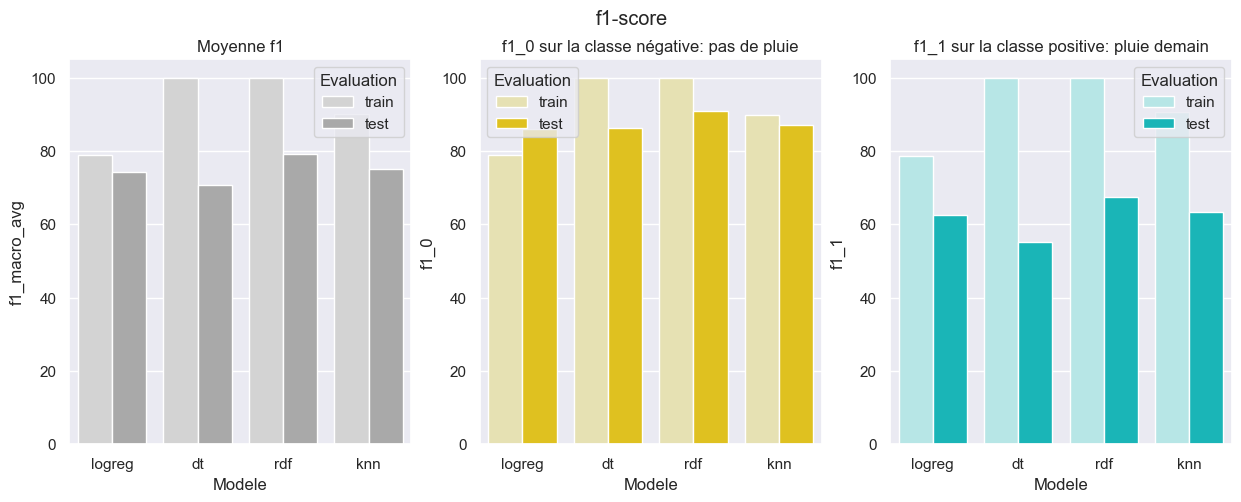

In [141]:
df_report = pd.read_csv('saves/reports/report.csv')
fig, axes = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('f1-score')

sns.barplot(ax = axes[0], data = df_report, x = 'Modele', y = 'f1_macro_avg', hue = 'Evaluation', palette= ['lightgrey', 'darkgrey'])
axes[0].set_title("Moyenne f1")
           
sns.barplot(ax = axes[1],data = df_report, x = 'Modele', y = 'f1_0', hue = 'Evaluation', palette=['palegoldenrod', 'gold'])
axes[1].set_title("f1_0 sur la classe négative: pas de pluie")

sns.barplot(ax = axes[2],data = df_report, x = 'Modele', y = 'f1_1', hue = 'Evaluation', palette=['paleturquoise', 'darkturquoise'])
axes[2].set_title("f1_1 sur la classe positive: pluie demain")

plt.show()

## 2. Essai de rééquilibrage sur logreg via la feature selection:

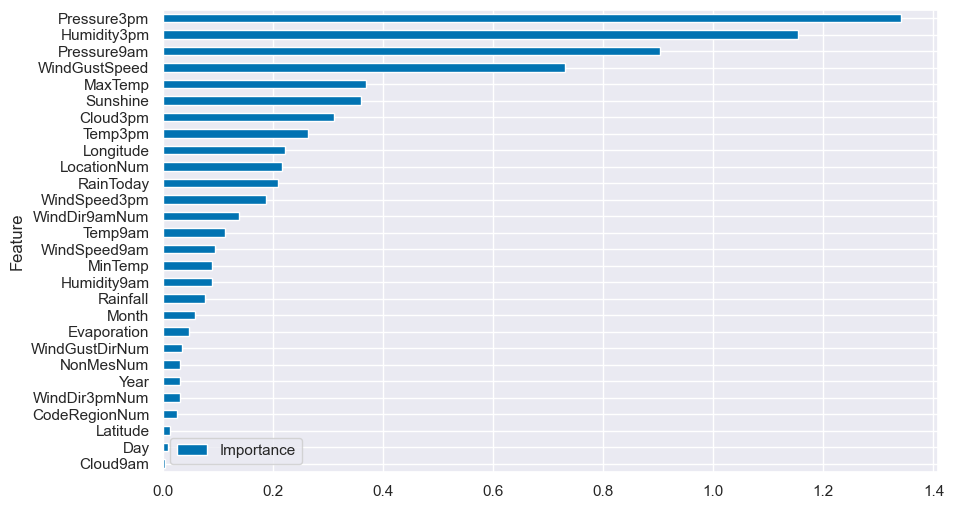

In [151]:
# Features importances pour logreg
# https://forecastegy.com/posts/feature-importance-in-logistic-regression/

logreg_best = load('saves/model_saves/save_logreg.joblib')

coefficients = logreg_best.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

feature_importance = feature_importance.sort_values('Importance', ascending=True, ignore_index = True).copy()

In [143]:
# Instanciation df 
df = pd.read_csv('../../data/processed/model_weatherAUS.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

# Séparation data / target:
X = df.drop(columns = ['RainTomorrow', 'Date']).copy()
y = df['RainTomorrow'].copy()

# Séparation du jeu d'entrainement et du jeu de test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify = y)

# Scale de X_train, X_test:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Oversample avec SMOTE
smote = SMOTE(random_state = 12, n_jobs = n_coeurs)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

# Recréation des df pour pouvoir enlever les colonnes avec la méthode .drop:
X_train_df = pd.DataFrame(X_sm, columns = X.columns)
X_test_df = pd.DataFrame(X_test, columns = X.columns)

dict_f1 = {}
keyList = ['NFeatsRemoved',  'f1_0_train', 'f1_1_train', 'f1_0_test', 'f1_1_test']
dict_f1 = {key: [] for key in keyList}

grid_logreg = load('saves/grid_saves/grid_logreg.joblib')

for i in range(feature_importance.shape[0]-1):
   
    # On enlève une feature et on convertit en numpy array::
    X_train = X_train_df.drop(columns = feature_importance['Feature'][0:i]).to_numpy()
    X_test = X_test_df.drop(columns = feature_importance['Feature'][0:i]).to_numpy()
    
    # Entrainement du modèle:
    y_train = y_sm
    clf = linear_model.LogisticRegression(C = grid_logreg.best_params_['C'], n_jobs = n_coeurs)
    clf.fit(X_train, y_train)
    
    # Prédiction:
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    
    # Evaluation:
    f1_0_test = f1_score(y_test, y_pred_test, pos_label = 0)
    f1_1_test = f1_score(y_test, y_pred_test, pos_label = 1)
    f1_0_train = f1_score(y_train, y_pred_train, pos_label = 0)
    f1_1_train = f1_score(y_train, y_pred_train, pos_label = 1)
    #f1_wavg = f1_score(y_test, y_pred, average = 'weighted')
    
    # Enregistrement
    dict_f1['NFeatsRemoved'].append(i+1)
    dict_f1['f1_0_train'].append(f1_0_train)
    dict_f1['f1_1_train'].append(f1_1_train)
    dict_f1['f1_0_test'].append(f1_0_test)
    dict_f1['f1_1_test'].append(f1_1_test)
    #dict_f1['f1_weighted_avg'].append(f1_wavg[2])
    
df_f1 = pd.DataFrame.from_dict(dict_f1)
df_f1.to_csv('saves/reports/logreg_feats_removed.csv')

C:\Users\AlexW\anaconda3\envs\projet_meteo\Lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


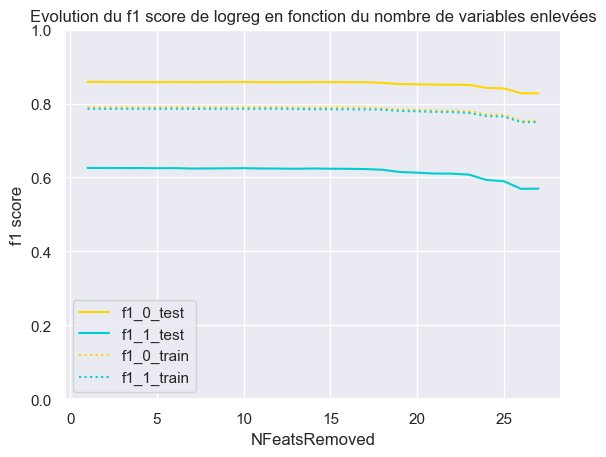

In [144]:
df_f1 = pd.read_csv('saves/reports/feats_removed.csv')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_0_test', label = 'f1_0_test', c = 'gold')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_1_test', label = 'f1_1_test', c = 'darkturquoise')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_0_train', label = 'f1_0_train', c = 'gold', linestyle = 'dotted')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_1_train', label = 'f1_1_train', c = 'darkturquoise', linestyle = 'dotted')
plt.ylim([0, 1])
plt.ylabel('f1 score')
plt.title("Evolution du f1 score de logreg en fonction du nombre de variables enlevées")
plt.legend()
plt.show()

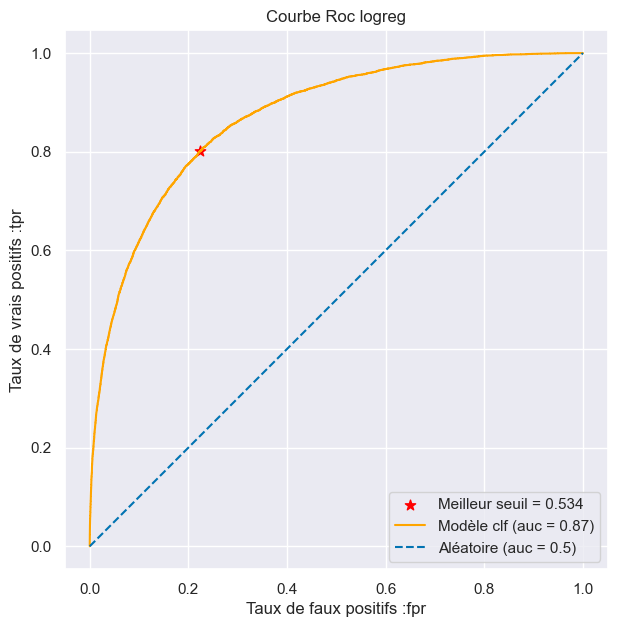

Report logreg 
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     27397
           1       0.54      0.75      0.63      7800

    accuracy                           0.81     35197
   macro avg       0.73      0.78      0.75     35197
weighted avg       0.84      0.81      0.82     35197

[[22532  4865]
 [ 1977  5823]]


In [9]:
logreg = load('saves/model_saves/save_logreg.joblib')
# On fait la prediction sur test:
preds = logreg.predict_proba(X_test)

################################ On cherche le meilleur seuil:
# Création des arrays fpr, tpr et seuils:
fpr, tpr, seuils = roc_curve(y_test, preds[:, 1], pos_label = 1) # on choisit pred[:, 1] pour prendre parmi les deux probas celle qui correspond à la classe positive.

# Pour calculer l'aire sous la courbe ROC:
roc_auc = auc(x = fpr, y = tpr)

# Comment trouver le meilleur seuil?
dist = 1
for (x, y, s) in zip(fpr, tpr, seuils):
    dist1 = np.square(x**2 + (y-1)**2) 
    if dist1 < dist:
        dist = dist1
        seuil_best = 1 - s # pourquoi dois-je faire ça?
        fpr_best = x
        tpr_best = y
        
#print("Meilleur seuil:", seuil_best, "meilleur fpr:", fpr_best, "meilleur tpr:", tpr_best)

# Tracé de ROC:
plt.figure(figsize = (7, 7))
plt.axis('equal')

plt.scatter(fpr_best, tpr_best, s = 60, c = 'red', marker = '*', alpha = 1, label = "Meilleur seuil = %0.3f" % seuil_best)
plt.plot(fpr, tpr, c = 'orange', label = 'Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (auc = 0.5)')

plt.title('Courbe Roc logreg')
plt.xlabel('Taux de faux positifs :fpr')
plt.ylabel('Taux de vrais positifs :tpr')
plt.legend()

plt.show()

################### On applique le meilleur seuil:
y_pred = pd.Series(np.where(preds[:, 1] > seuil_best, 1, 0))

print("Report logreg", "\n", classification_report(y_test, y_pred,  digits = 2))
print(confusion_matrix(y_test, y_pred))

Bilan: C'est assez mauvais: la précision de la classe positive laisse trop à désirer.

## 3. Essai de rééquilibrage sur RdF via feature selection

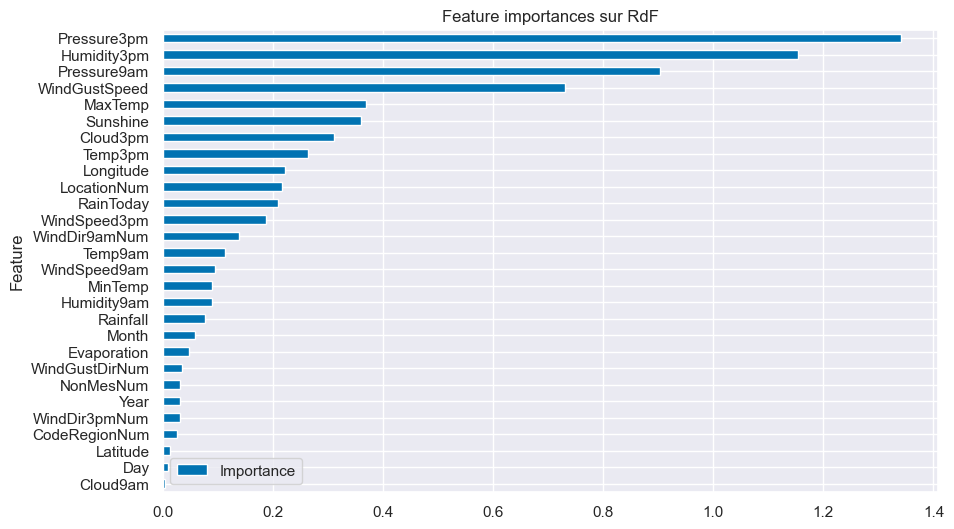

In [156]:
# Features importances pour rdf:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

rdf_best = load('saves/model_saves/save_rdf.joblib')

coefficents = rdf_best.feature_importances_
feature_importance = pd.DataFrame({'Feature' : X.columns, 'Importance' : np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending = True)
feature_importance.plot(x = 'Feature', y = 'Importance', kind = 'barh', figsize = (10, 6))
plt.title('Feature importances sur RdF')
plt.show()

feature_importance = feature_importance.sort_values('Importance', ascending=True, ignore_index = True).copy()


In [157]:
# Instanciation df 
df = pd.read_csv('../../data/processed/model_weatherAUS.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

# Séparation data / target:
X = df.drop(columns = ['RainTomorrow', 'Date']).copy()
y = df['RainTomorrow'].copy()

# Séparation du jeu d'entrainement et du jeu de test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify = y)

# Scale de X_train, X_test:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Oversample avec SMOTE
smote = SMOTE(random_state = 12, n_jobs = n_coeurs)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

# Recréation des df pour pouvoir enlever les colonnes avec la méthode .drop:
X_train_df = pd.DataFrame(X_sm, columns = X.columns)
X_test_df = pd.DataFrame(X_test, columns = X.columns)

dict_f1 = {}
keyList = ['NFeatsRemoved',  'f1_0_train', 'f1_1_train', 'f1_0_test', 'f1_1_test']
dict_f1 = {key: [] for key in keyList}

grid_rdf= load('saves/grid_saves/grid_rdf.joblib')
rdf_best = load('saves/model_saves/save_rdf.joblib')

for i in range(feature_importance.shape[0]-1):
   
    # On enlève une feature et on convertit en numpy array::
    X_train = X_train_df.drop(columns = feature_importance['Feature'][0:i]).to_numpy()
    X_test = X_test_df.drop(columns = feature_importance['Feature'][0:i]).to_numpy()
    
    # Entrainement du modèle:
    y_train = y_sm
    clf = rdf_best
    clf.fit(X_train, y_train)
    
    # Prédiction:
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    
    # Evaluation:
    f1_0_test = f1_score(y_test, y_pred_test, pos_label = 0)
    f1_1_test = f1_score(y_test, y_pred_test, pos_label = 1)
    f1_0_train = f1_score(y_train, y_pred_train, pos_label = 0)
    f1_1_train = f1_score(y_train, y_pred_train, pos_label = 1)
    #f1_wavg = f1_score(y_test, y_pred, average = 'weighted')
    
    # Enregistrement
    dict_f1['NFeatsRemoved'].append(i+1)
    dict_f1['f1_0_train'].append(f1_0_train)
    dict_f1['f1_1_train'].append(f1_1_train)
    dict_f1['f1_0_test'].append(f1_0_test)
    dict_f1['f1_1_test'].append(f1_1_test)
    #dict_f1['f1_weighted_avg'].append(f1_wavg[2])
    
df_f1 = pd.DataFrame.from_dict(dict_f1)
df_f1.to_csv('saves/reports/rdf_feats_removed.csv')

C:\Users\AlexW\anaconda3\envs\projet_meteo\Lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


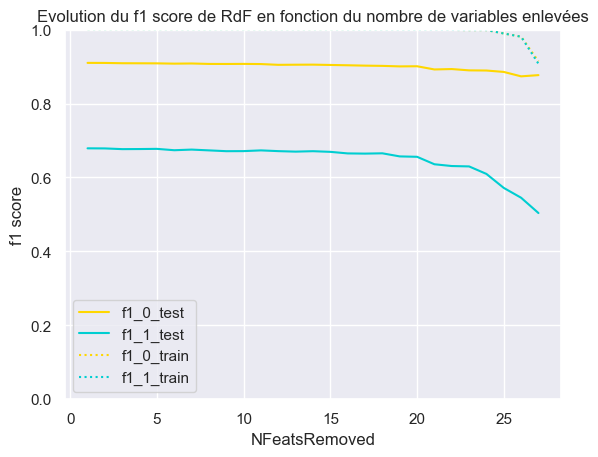

In [158]:
df_f1 = pd.read_csv('saves/reports/rdf_feats_removed.csv')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_0_test', label = 'f1_0_test', c = 'gold')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_1_test', label = 'f1_1_test', c = 'darkturquoise')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_0_train', label = 'f1_0_train', c = 'gold', linestyle = 'dotted')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_1_train', label = 'f1_1_train', c = 'darkturquoise', linestyle = 'dotted')
plt.ylim([0, 1])
plt.ylabel('f1 score')
plt.title("Evolution du f1 score de RdF en fonction du nombre de variables enlevées")
plt.legend()
plt.show()

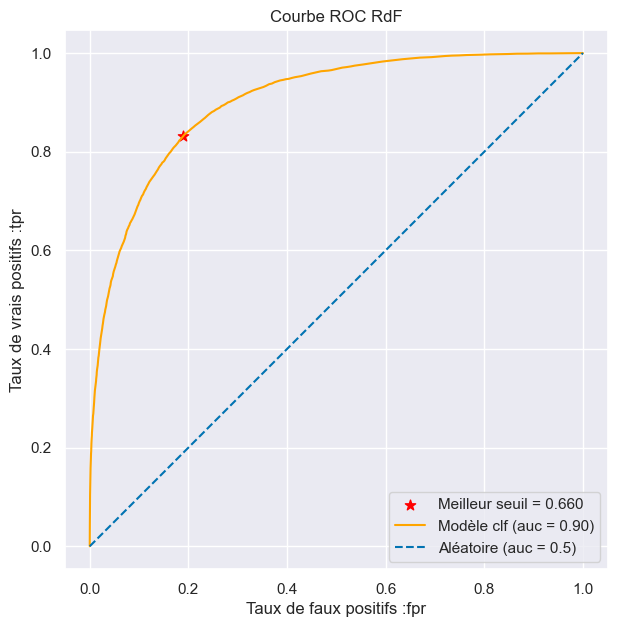

Report RdF 
               precision    recall  f1-score   support

           0       0.87      0.97      0.92     27397
           1       0.80      0.50      0.61      7800

    accuracy                           0.86     35197
   macro avg       0.84      0.73      0.76     35197
weighted avg       0.86      0.86      0.85     35197

[[26454   943]
 [ 3938  3862]]


In [7]:
rdf = load('saves/model_saves/save_rdf.joblib')
# On fait la prediction sur test:
preds = rdf.predict_proba(X_test)

################################ On cherche le meilleur seuil:
# Création des arrays fpr, tpr et seuils:
fpr, tpr, seuils = roc_curve(y_test, preds[:, 1], pos_label = 1) # on choisit pred[:, 1] pour prendre parmi les deux probas celle qui correspond à la classe positive.

# Pour calculer l'aire sous la courbe ROC:
roc_auc = auc(x = fpr, y = tpr)

# Comment trouver le meilleur seuil?
dist = 1
for (x, y, s) in zip(fpr, tpr, seuils):
    dist1 = np.square(x**2 + (y-1)**2) 
    if dist1 < dist:
        dist = dist1
        seuil_best = 1 - s # pourquoi dois-je faire ça?
        fpr_best = x
        tpr_best = y
        
#print("Meilleur seuil:", seuil_best, "meilleur fpr:", fpr_best, "meilleur tpr:", tpr_best)

# Tracé de ROC:
plt.figure(figsize = (7, 7))
plt.axis('equal')

plt.scatter(fpr_best, tpr_best, s = 60, c = 'red', marker = '*', alpha = 1, label = "Meilleur seuil = %0.3f" % seuil_best)
plt.plot(fpr, tpr, c = 'orange', label = 'Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (auc = 0.5)')

plt.title('Courbe ROC RdF')
plt.xlabel('Taux de faux positifs :fpr')
plt.ylabel('Taux de vrais positifs :tpr')
plt.legend()

plt.show()

################### On applique le meilleur seuil:
y_pred = pd.Series(np.where(preds[:, 1] > seuil_best, 1, 0))

print("Report RdF", "\n", classification_report(y_test, y_pred,  digits = 2))
print(confusion_matrix(y_test, y_pred))

Bilan: RdF seuillé obtient le meilleur f1_score, c'est peut être le modèle le plus équilibré à ce jour (14 nov 23, 12h00)